## 1. Configuració inicial i càrrega del fitxer GDF

Aquesta secció configura l'entorn per a la càrrega de dades EEG des d'un fitxer GDF. 
Inicialment, obtenim el directori actual de treball i, a continuació, construïm el camí absolut al fitxer GDF. 
Si el fitxer existeix, es carrega utilitzant la biblioteca MNE i es mostra la informació de les dades carregades.

In [28]:
import os
import mne

# Get the current working directory
current_directory = os.getcwd()

# Move up one directory to the parent directory
parent_directory = os.path.dirname(current_directory)

# Define the relative path to the GDF file
relative_gdf_file_path = 'dataset/B0101T.gdf'

# Build the absolute path to the GDF file
gdf_file_path = os.path.join(parent_directory, relative_gdf_file_path)

# Check if the file exists
if os.path.exists(gdf_file_path):
    # Load the data using MNE
    raw_data = mne.io.read_raw_gdf(gdf_file_path, preload=True)
    # Print the information about the channels
    raw_data.info
else:
    "GDF file not found or could not be loaded."

Extracting EDF parameters from /Users/superjordi/repos/uoc/TFG/exp1_bciciv_ds_b/dataset/B0101T.gdf...
GDF file detected
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG:C3, EEG:Cz, EEG:C4, EOG:ch01, EOG:ch02, EOG:ch03
Creating raw.info structure...
Reading 0 ... 604802  =      0.000 ...  2419.208 secs...


/var/folders/lt/rksts1mn7p7f78615mlf9g7h0000gn/T/ipykernel_18743/3059637042.py:19: RuntimeWarning: Highpass cutoff frequency 100.0 is greater than lowpass cutoff frequency 0.5, setting values to 0 and Nyquist.
  raw_data = mne.io.read_raw_gdf(gdf_file_path, preload=True)


## 2. Extracció i visualització d'informació de canals i esdeveniments

Aquesta secció extreu i mostra la informació dels canals i els esdeveniments de les dades EEG. 
Incloent els noms dels canals, els tipus de canals i la informació dels esdeveniments anotats. 
Això proporciona una visió general dels components de les dades EEG abans de la seva anàlisi detallada.

In [29]:
# Extracting the channel names and types from the data
channel_info = raw_data.info['chs']
channel_names = [ch['ch_name'] for ch in channel_info]
channel_types = [ch['kind'] for ch in channel_info]

# Extracting event information
events, event_id = mne.events_from_annotations(raw_data)

# Displaying channel names, types, and event information
channel_names, channel_types, event_id

Used Annotations descriptions: ['1023', '1077', '1078', '1079', '1081', '276', '277', '32766', '768', '769', '770']


(['EEG:C3', 'EEG:Cz', 'EEG:C4', 'EOG:ch01', 'EOG:ch02', 'EOG:ch03'],
 [2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH),
  2 (FIFFV_EEG_CH)],
 {'1023': 1,
  '1077': 2,
  '1078': 3,
  '1079': 4,
  '1081': 5,
  '276': 6,
  '277': 7,
  '32766': 8,
  '768': 9,
  '769': 10,
  '770': 11})

## 3. Inspecció visual de les dades EEG i EOG

Aquí, realitzem una inspecció visual de les dades EEG i EOG. 
Es mostren segments curts de dades per a una avaluació ràpida de la seva qualitat i per identificar possibles artefactes. 
Aquesta anàlisi visual és un pas important abans del processament més detallat de les dades.

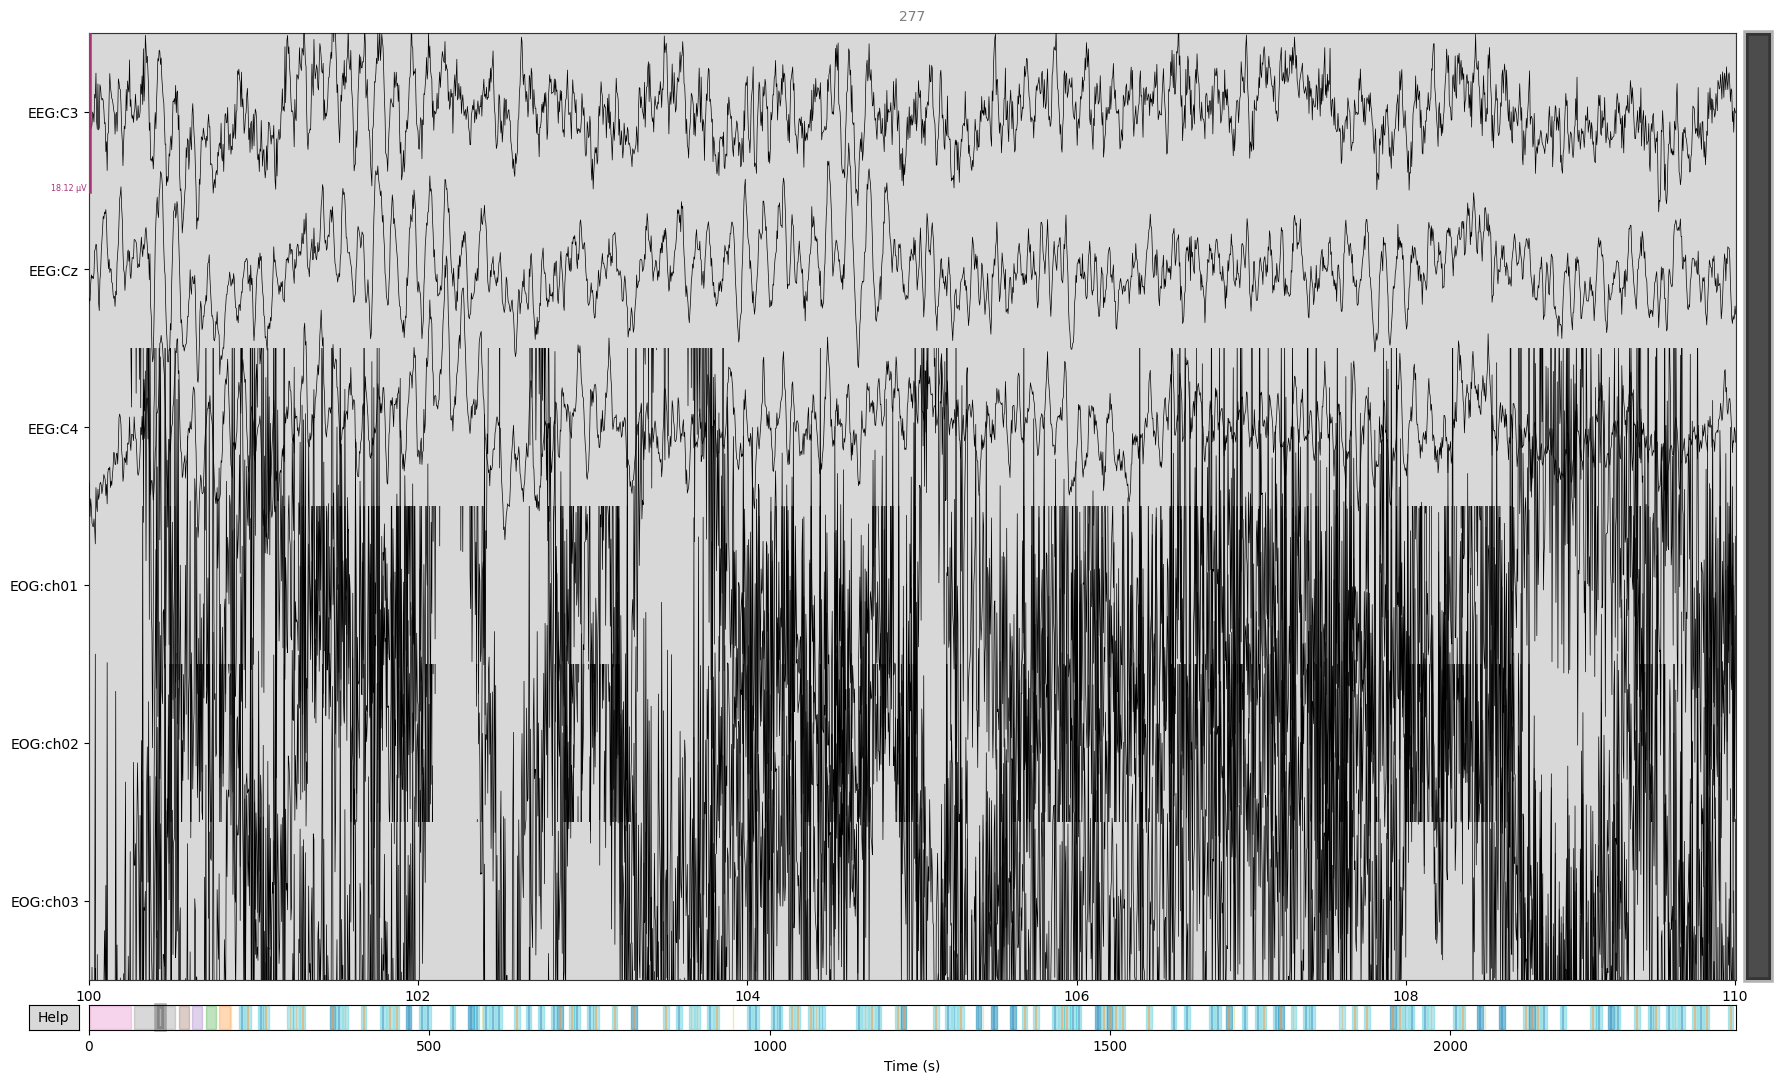

In [30]:
import matplotlib.pyplot as plt

# Plotting a short segment of the EEG and EOG data for visual inspection
plot_duration = 10  # in seconds
start_time = 100  # start time for the plot, in seconds

# Plot EEG data
raw_data.copy().pick('eeg').plot(start=start_time, duration=plot_duration, scalings='auto', title='EEG Data')

# Check if EOG channels are present and plot EOG data
channel_types = [mne.channel_type(raw_data.info, idx) for idx in range(raw_data.info['nchan'])]
if 'eog' in channel_types:
    raw_data.copy().pick('eog').plot(start=start_time, duration=plot_duration, scalings='auto', title='EOG Data')
else:
    "No EOG channels found."

plt.show()

## 4. Creació d'epochs i inspecció visual de les mateixes

En aquesta secció, es creen epochs basades en esdeveniments de motor imagery i es realitza una inspecció visual d'unes quantes d'aquestes epochs. 
Les epochs són segments temporals de dades EEG al voltant d'esdeveniments específics, i la seva visualització ajuda a comprendre les dinàmiques temporals associades a diferents tipus d'activitat cerebral.

Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 120 events and 1251 original time points ...
0 bad epochs dropped


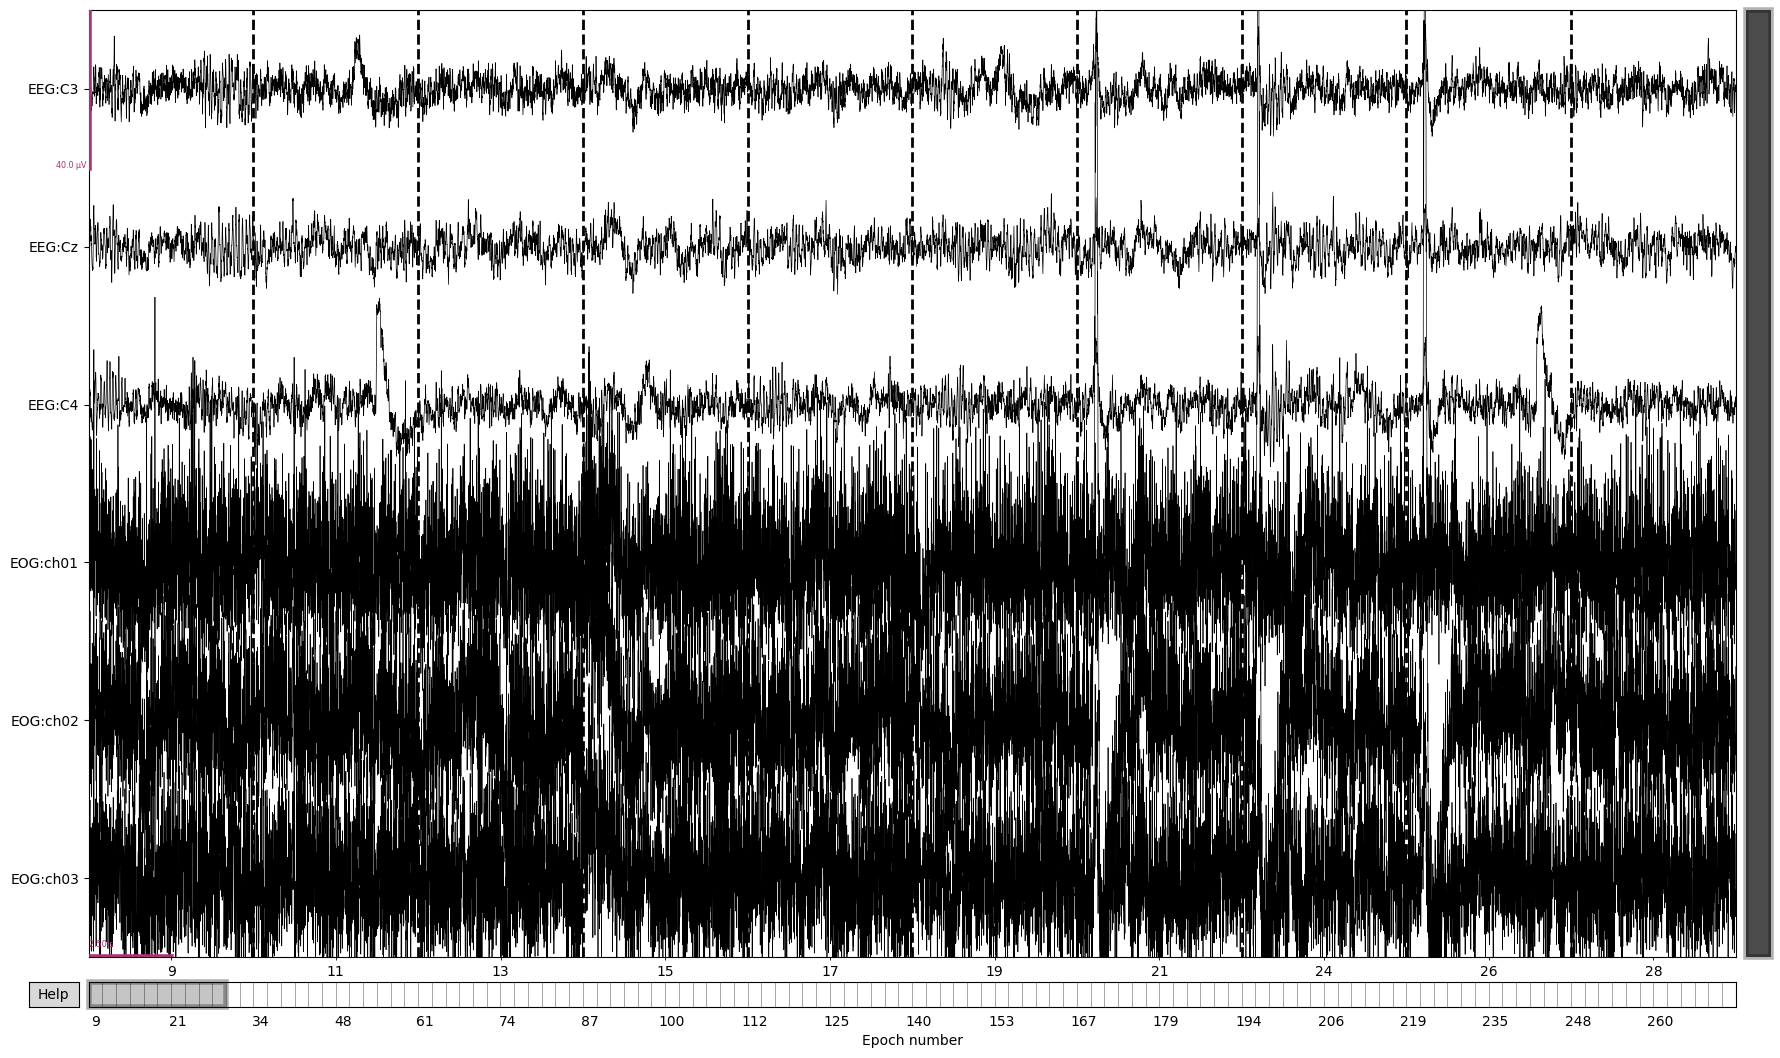

/var/folders/lt/rksts1mn7p7f78615mlf9g7h0000gn/T/ipykernel_18743/1502128185.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  epochs.plot(n_epochs=10, n_channels=len(picks)).show()  # Plotting a few epochs for inspection)


<Epochs |  120 events (all good), -1 – 4 s, baseline off, ~6.9 MB, data loaded,
 'Left Hand': 60
 'Right Hand': 60>

In [31]:
# Let's take a closer look at the events and their IDs
events_extracted = list(event_id.keys())
events_extracted.sort()

# Display the sorted list of extracted event descriptions and their corresponding IDs
events_extracted, [event_id[ev] for ev in events_extracted]

from mne import Epochs, pick_types

# Define the event IDs for left hand (class 1) and right hand (class 2) motor imagery
# We use the event IDs as they are represented in the data (10 for left hand, 11 for right hand)
event_id_motor_imagery = {'Left Hand': 10, 'Right Hand': 11}

# Define the time interval around the events for epoching (e.g., from -1 to 4 seconds)
tmin, tmax = -1, 4

# Pick EEG channels for epoching
picks = pick_types(raw_data.info, eeg=True, eog=False)

# Create epochs for motor imagery events
epochs = Epochs(raw_data, events, event_id_motor_imagery, tmin, tmax, proj=True, picks=picks, baseline=None, preload=True)

epochs.plot(n_epochs=10, n_channels=len(picks)).show()  # Plotting a few epochs for inspection)

# Display the shape of the epochs array
epochs

## 5. Filtratge de les epochs per a anàlisi específica de bandes de freqüència:

Aquesta secció aplica un filtre de banda passa a les èpoques per centrar-se en bandes de freqüència específiques que són rellevants per a l'anàlisi de tipus motor imagery. 
El filtratge ajuda a reduir el soroll i millora la claredat dels senyals per a anàlisis posteriors.

Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s


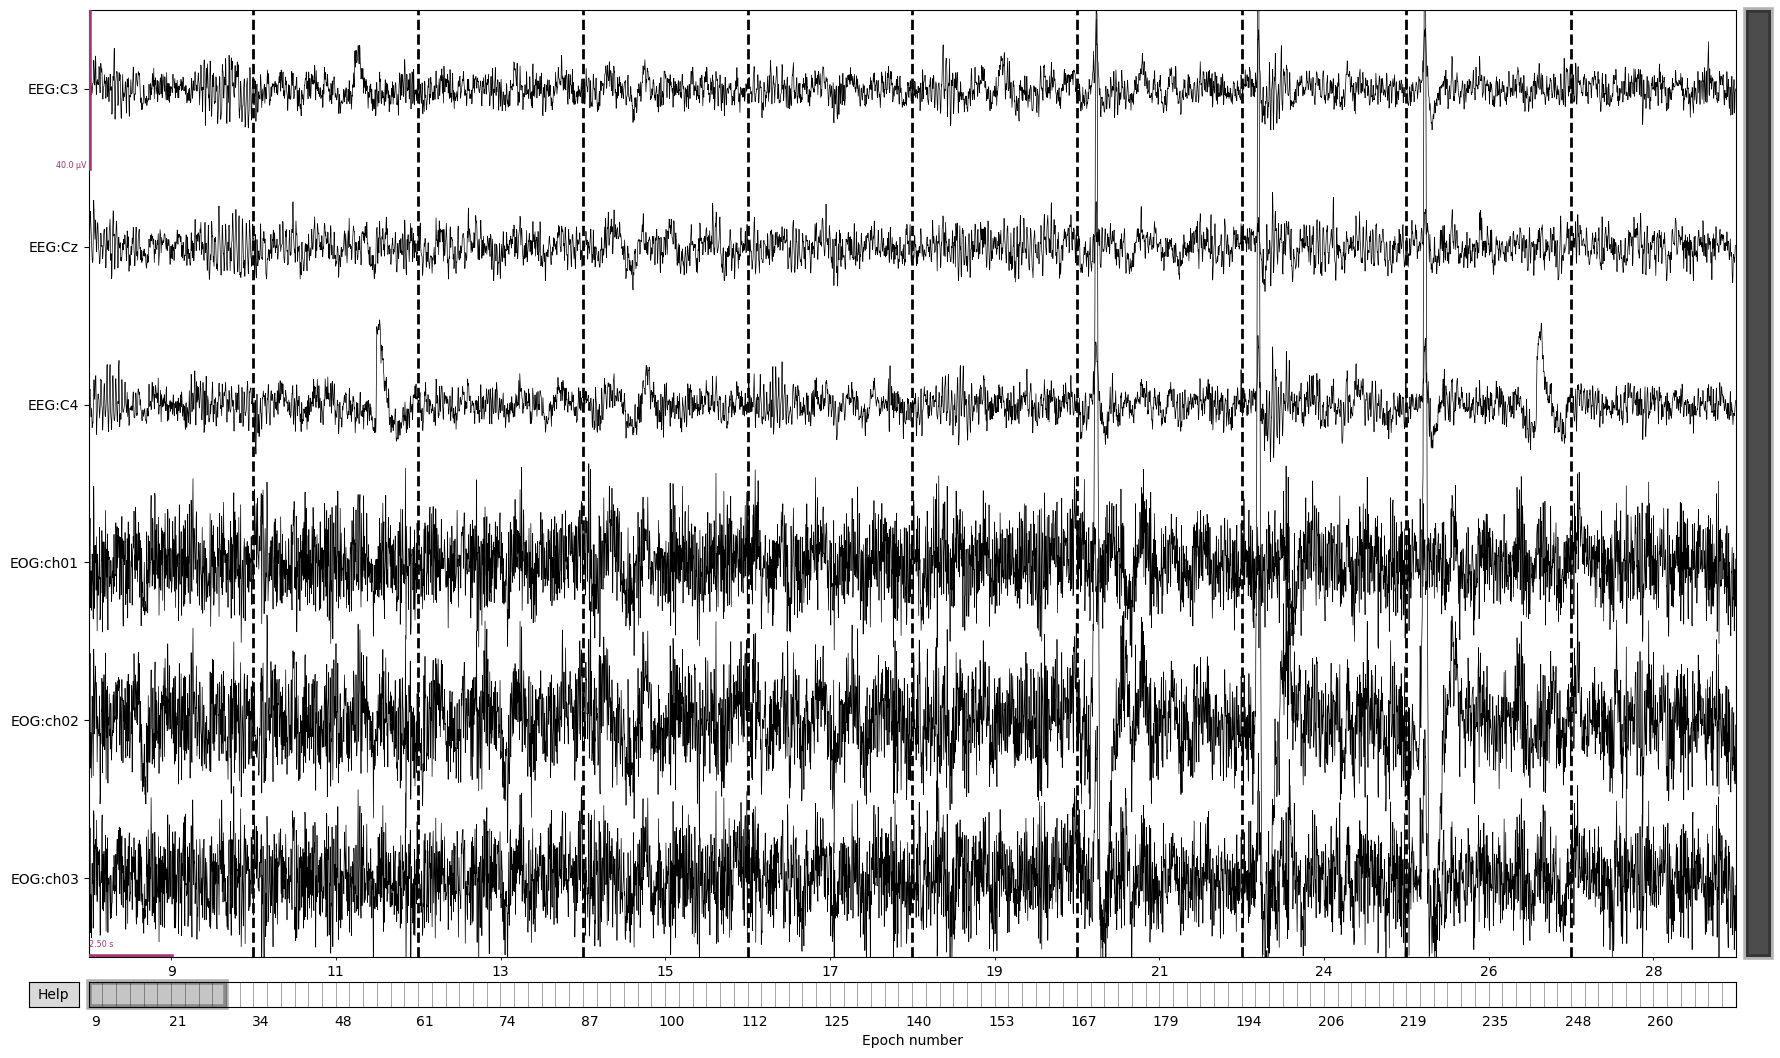

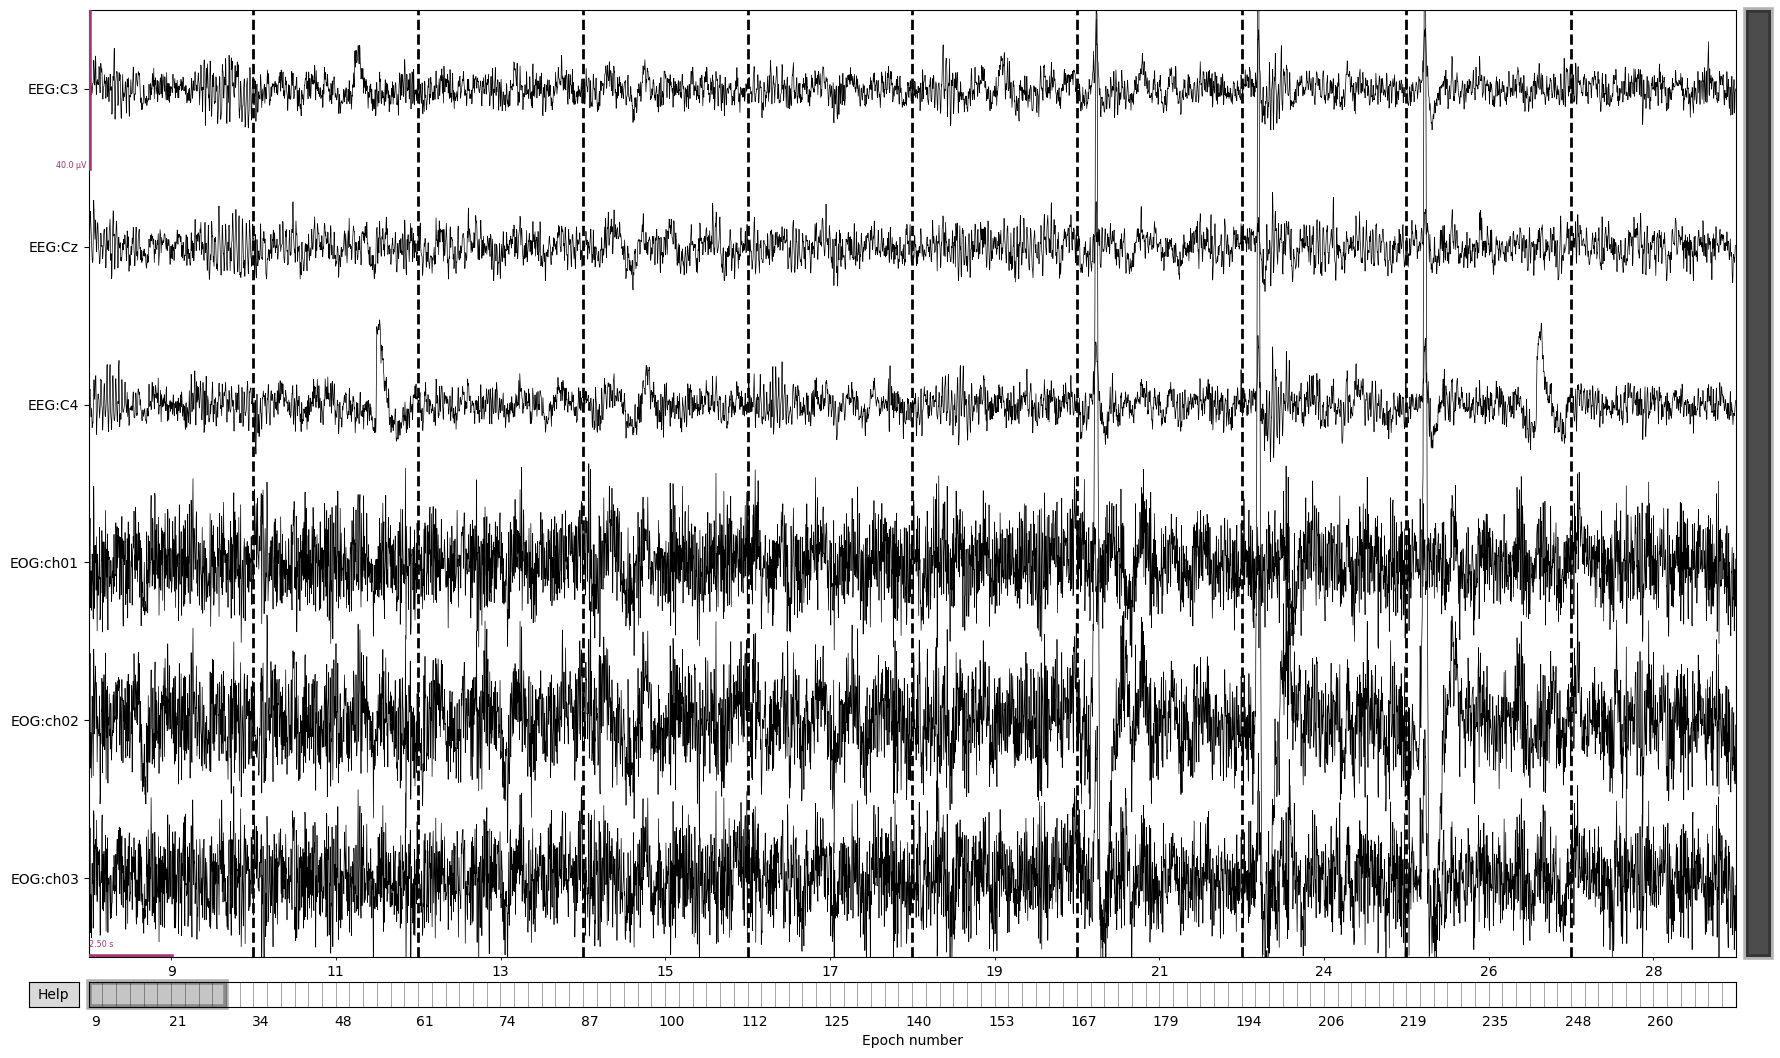

In [32]:
# Applying band-pass filter to the data
low_freq, high_freq = 1, 40  # Low and high cut-off frequencies

# Applying the filter to the EEG data
filtered_epochs = epochs.copy().filter(low_freq, high_freq, fir_design='firwin')

# Plotting the filtered data for a few epochs for visual inspection
filtered_epochs.plot(n_epochs=10, n_channels=len(picks))


## 6. Aplicació de l'Anàlisi de Components Independents (ICA)

L'ICA és utilitzada aquí per identificar i eliminar artefactes com parpelleigs o moviments musculars. 
Aquesta secció mostra com inicialitzar i ajustar ICA, i com visualitzar els components per a la identificació d'artefactes. 
És una tècnica clau en el preprocessament de dades EEG per a obtenir senyals més nets.

Fitting ICA to data using 6 channels (please be patient, this may take a while)
Selecting by number: 6 components
Fitting ICA took 1.0s.
Not setting metadata
120 matching events found
No baseline correction applied
0 projection items activated


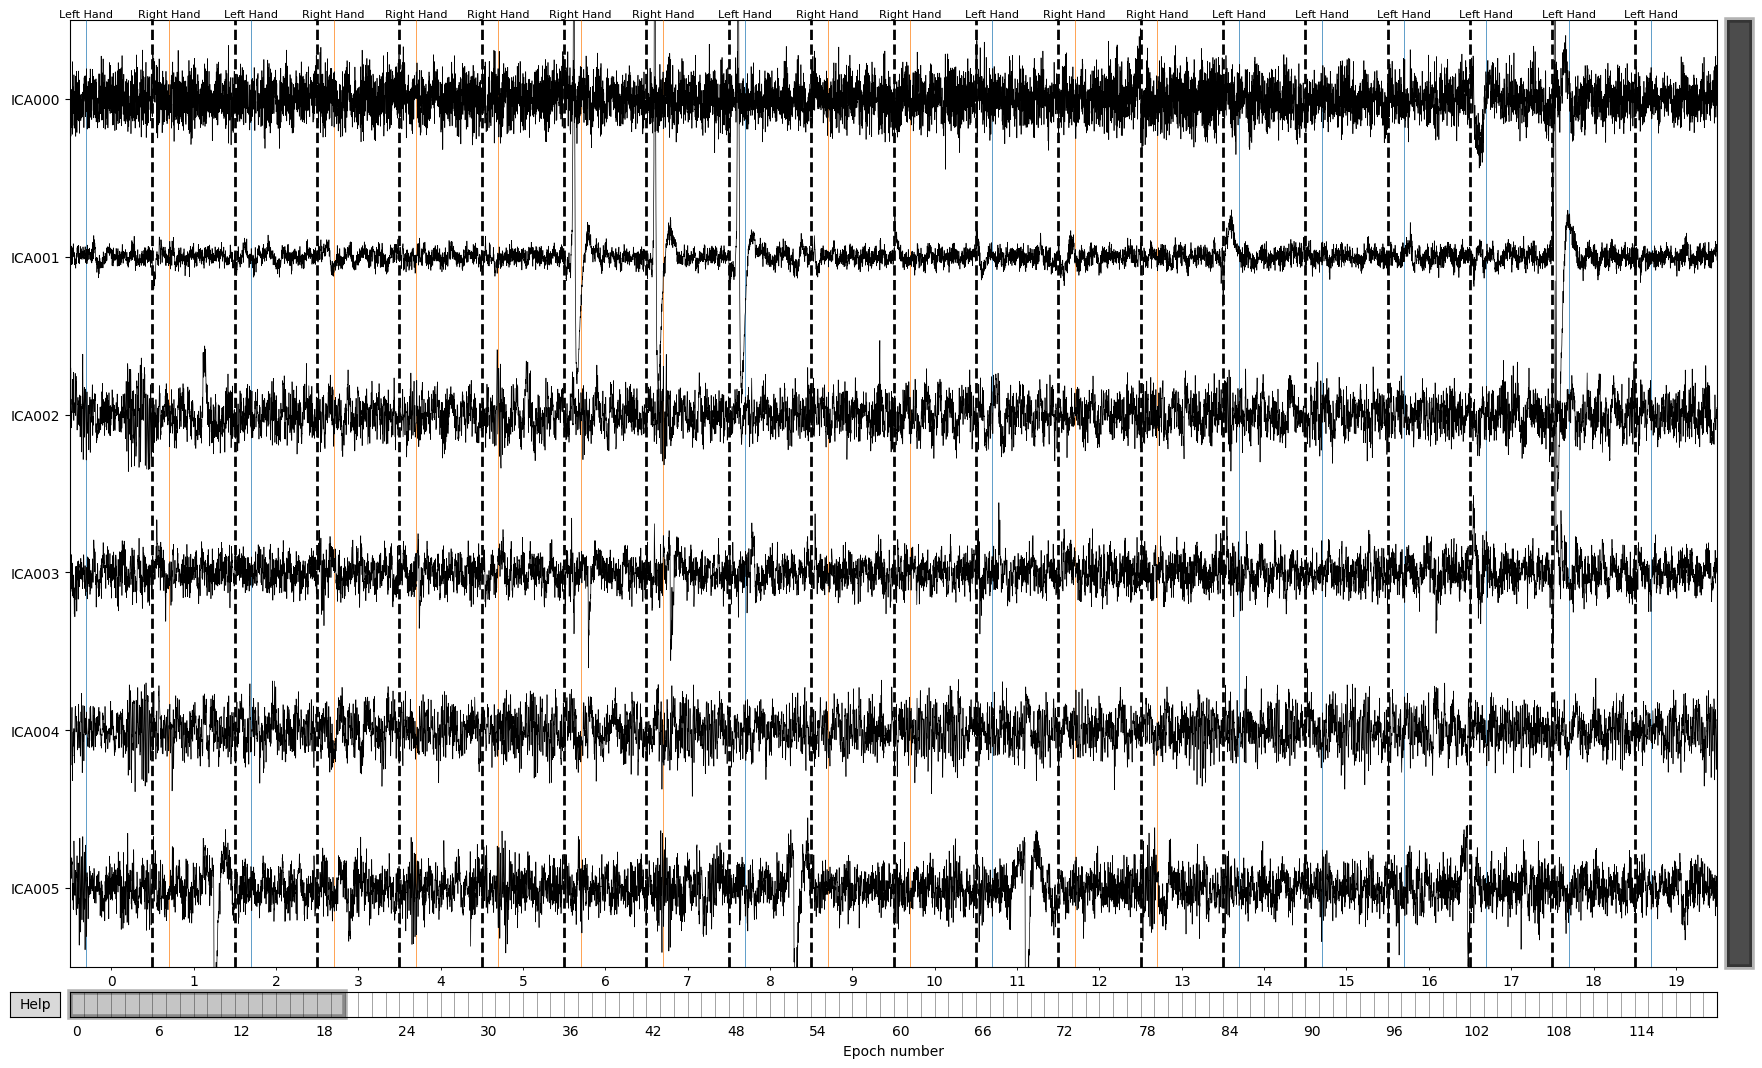

Applying ICA to Epochs instance
    Transforming to ICA space (6 components)
    Zeroing out 2 ICA components
    Projecting back using 6 PCA components


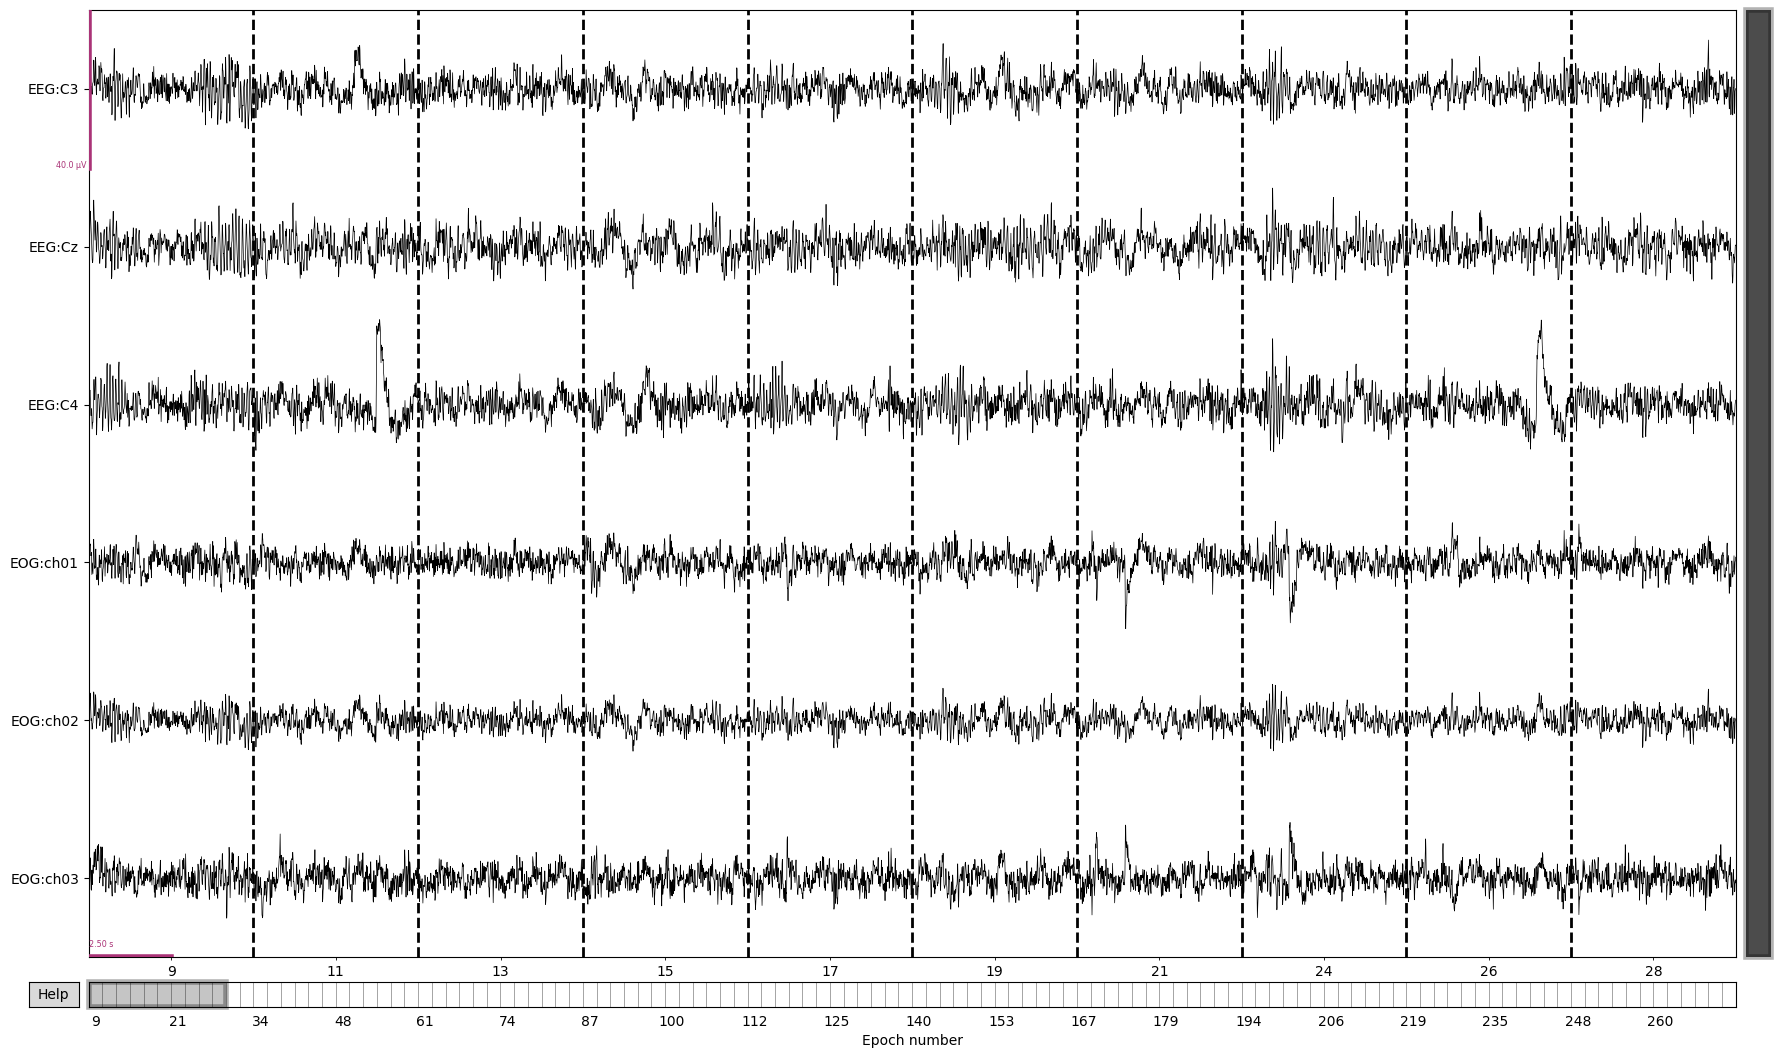

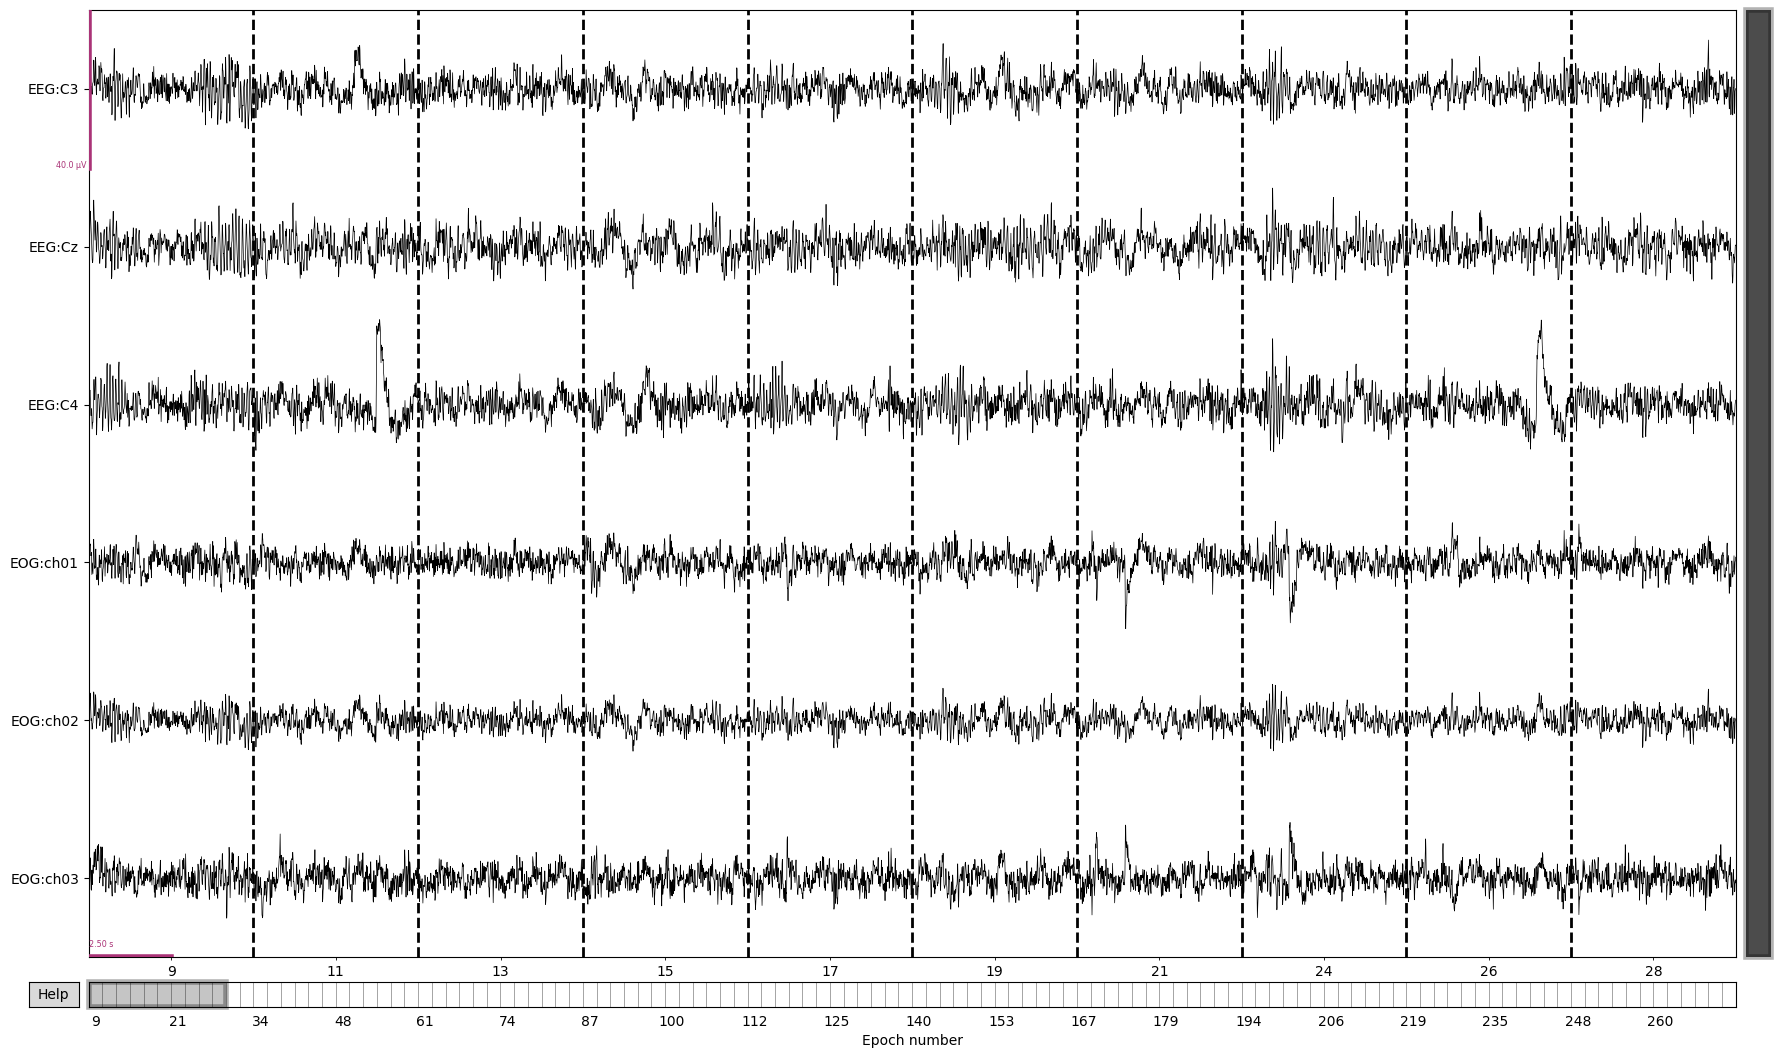

In [33]:
from mne.preprocessing import ICA

# Número de components per a ICA
n_components = len(filtered_epochs.ch_names)

# Inicialitza i ajusta ICA
ica = ICA(n_components=n_components, random_state=97, max_iter=800)
ica.fit(filtered_epochs)

# Traça els components ICA (les fonts)
ica.plot_sources(filtered_epochs, show_scrollbars=True)

# Guarda el gràfic si és necessari
# ica.plot_sources(filtered_epochs).savefig('ica_sources_plot.png')

"""
from itertools import combinations

n_ica_components = len(ica.ch_names)

# Limit per al nombre de components a excloure en cada prova
max_excluded = 2

# Prepara els epochs originals per a la comparació
original_epochs = filtered_epochs.copy()

# Bucle per a provar totes les combinacions possibles
for n in range(max_excluded + 1):
    for components_to_exclude in combinations(range(n_ica_components), n):
        # Exclou els components seleccionats
        ica.exclude = list(components_to_exclude)

        # Aplica ICA als epochs filtrats
        cleaned_epochs = ica.apply(original_epochs.copy())

        # Visualitza els senyals nets
        print(f"Provant amb components exclosos: {components_to_exclude}")
        cleaned_epochs.plot(n_epochs=10, n_channels=len(original_epochs.ch_names))

La combinació on s'elimina les components 0,1 es la que millors resultats dóna, per tant, la utilitzarem
"""
# Prepara els epochs originals per a la comparació
original_epochs = filtered_epochs.copy()

# Exclou els components seleccionats
ica.exclude = [0, 1]

# Aplica ICA als epochs filtrats
cleaned_epochs = ica.apply(original_epochs.copy())

# Visualitza els senyals nets
cleaned_epochs.plot(n_epochs=10, n_channels=len(original_epochs.ch_names))

## 7. Extracció de característiques utilitzant la potència espectral

En aquesta secció, ens concentrem en l'extracció de característiques a partir de les bandes de freqüència alfa i beta. 
Utilitzem la potència espectral com a mètode d'extracció, que és crucial per a l'anàlisi de les dades de tipus motor imagery. 
Aquestes característiques seran utilitzades posteriorment per a la classificació.

In [34]:
import numpy as np

# Defineix les bandes de freqüència
freq_bands = {'alpha': (8, 13),
              'beta': (13, 30)}

# Calcula la PSD per a tots els epochs
psd = cleaned_epochs.compute_psd(fmin=5, fmax=40, method='welch')
freqs = psd.freqs
psd_data = psd.get_data()

# Inicialitza una llista per emmagatzemar les característiques
features = []

# Itera sobre els psd_data (un array per cada epoch)
for psd_epoch in psd_data:
    # Inicialitza un diccionari per a les característiques d'aquest epoch
    epoch_features = {}

    # Calcula la potència mitjana en cada banda de freqüència
    for band, (fmin, fmax) in freq_bands.items():
        # Troba els índexs de freqüència dins de la banda
        freq_mask = (freqs >= fmin) & (freqs <= fmax)

        # Mitjana de la potència espectral dins de la banda
        mean_band_power = np.mean(psd_epoch[:, freq_mask], axis=1)
        epoch_features[band] = mean_band_power

    features.append(epoch_features)

# `features` ara conté les característiques de potència espectral per a cada epoch
features


Effective window size : 5.004 (s)


[{'alpha': array([4.39895663e-13, 4.15453276e-13, 2.90050292e-13, 1.27058431e-13,
         1.95796570e-13, 1.69039082e-13]),
  'beta': array([1.06697180e-13, 1.03277291e-13, 1.75339989e-13, 1.07734075e-13,
         6.84496989e-14, 1.06352971e-13])},
 {'alpha': array([1.10710923e-13, 4.75545108e-13, 2.57731203e-13, 8.25510799e-14,
         1.19093650e-13, 1.51466599e-13]),
  'beta': array([9.96866652e-14, 9.35422199e-14, 1.38009676e-13, 8.09408392e-14,
         5.85834304e-14, 1.19525574e-13])},
 {'alpha': array([2.08210664e-13, 2.20000280e-13, 1.16681232e-13, 1.30585873e-13,
         1.04720804e-13, 1.68331393e-13]),
  'beta': array([1.31904803e-13, 1.54571441e-13, 1.32049844e-13, 1.04413669e-13,
         8.29225157e-14, 9.48594444e-14])},
 {'alpha': array([1.44549158e-13, 3.94358684e-13, 2.44394158e-13, 1.39161571e-13,
         1.13319870e-13, 1.30750637e-13]),
  'beta': array([1.01171777e-13, 1.12252264e-13, 1.84659925e-13, 7.81596006e-14,
         6.18988692e-14, 1.00999086e-13])},


## 8. Preparació de dades per a classificació amb SVM

Aquí, preparem les característiques i les etiquetes per a ser utilitzades en un model de classificació SVM. 
Això inclou la normalització de les característiques i la conversió de les etiquetes a un format adequat per al model. (Matricial)

In [35]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# `features` és la llista de característiques
# i `labels` és la llista d'etiquetes.

# Convertir les característiques en una matriu
X = np.array([np.concatenate([feat['alpha'], feat['beta']]) for feat in features])

# Normalitzar les característiques
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Mostrar X_scaled
X_scaled

# Extreure les etiquetes dels epochs
labels = epochs.events[:, -1]

# Mapejar els identificadors d'esdeveniments a etiquetes binàries (0 per a 'Left Hand', 1 per a 'Right Hand')
# Això depèn dels IDs d'esdeveniment específics que hem utilitzat per a 'Left Hand' i 'Right Hand'
label_map = {10: 0, 11: 1}
y = np.array([label_map[label] for label in labels])

# Mostrar y
y

array([0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 1])

## 9. Implementació i avaluació del classificador SVM

Finalment, implementem i avaluem un classificador SVM. 
Això inclou la divisió de les dades en conjunts d'entrenament i prova, l'entrenament del model, la realització de prediccions i l'avaluació de la seva precisió, mitjançant diverses mètriques com la matriu de confusió i l'informe de classificació. 
Aquesta secció culmina el flux de treball d'anàlisi de dades EEG.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

# Dividir les dades en conjunts d'entrenament i prova
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Crear el model SVM
svm_model = SVC(kernel='linear')  # altres kernels: 'linear', 'poly', 'rbf', etc.

# Entrenar el model
svm_model.fit(X_train, y_train)

# Fer prediccions amb les dades de prova
y_pred = svm_model.predict(X_test)

# Calcular mètriques d'avaluació
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
kappa_score = cohen_kappa_score(y_test, y_pred)

# Mostrar els resultats
print("Exactitud (Accuracy):", accuracy)
print("Matrís de Confusió:\n", conf_matrix)
print("Informe de Classificació:\n", class_report)
print("Puntuació Kappa:", kappa_score)


Exactitud (Accuracy): 0.625
Matrís de Confusió:
 [[7 2]
 [7 8]]
Informe de Classificació:
               precision    recall  f1-score   support

           0       0.50      0.78      0.61         9
           1       0.80      0.53      0.64        15

    accuracy                           0.62        24
   macro avg       0.65      0.66      0.62        24
weighted avg       0.69      0.62      0.63        24

Puntuació Kappa: 0.28
